## Language Complexity through Complex Networks

The metrics extracted from the complex networks respresenting text and pattern recognition methods to analyse complexity in texts.

The correlation is established between language complexity and network topology.

### Intro

Networks represent texts, whose topology is examined through several metrics. The patterns emerging from the topological features are investigated with clustering to correlate with textual complexity.

In [1]:
# imports
import matplotlib.pyplot as plt
import networkx as nx
from typing import List, Tuple
%matplotlib inline

In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [3]:
from itertools import combinations


def make_edgelist(word_list: List, word_distance: int) -> List[Tuple]:
    """
    Creates edgelist by taking list of words and word_distance. 
    For example, if word_distance is equal to 2, 
    two words are connected if there was at most one intermediate
    word separating them in the preprocessed text.
    """
    edgelist = []
    for i in range(len(word_list)-word_distance):
        subset = word_list[i:i+1+word_distance]
        comb = combinations(subset, 2)
        for apair in comb:
            edgelist.append(apair)
    return edgelist

### Network Formation

In [4]:
demo = nx.Graph()
sent = "yellow fog rub back window pane yellow smoke rub muzzle window pane".split()
demo.add_edges_from(make_edgelist(sent, 2))

/home/akhilesh/venv/p3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


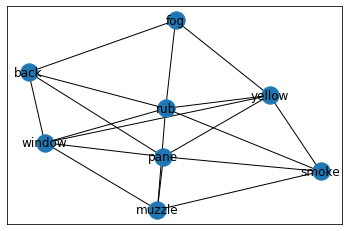

In [5]:
nx.draw_networkx(demo)

#### Pre-processing

In [6]:
import pandas as pd

In [13]:
# data = pd.read_csv("data/stories.csv").dropna()

In [14]:
# english_data = data[data["story_langugage"] == "English"]

In [8]:
import os
idir = "/home/akhilesh/civicdatalab/samantar_parsers/data/txts/"
df = pd.DataFrame()
all_data = []
for filename in os.listdir(idir):
    if filename.endswith('.txt'):
        with open(idir + filename, 'r') as f:
            data = f.readlines()
        stripped_data = list(map(lambda x: x.strip(), data))
        clean_data = ' '.join(stripped_data)
        corr = (filename.split(".")[0], clean_data)
        all_data.append(corr)

In [10]:
df = pd.DataFrame(all_data)
df.columns = ['year', 'content']

In [12]:
import nltk

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/akhilesh/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [15]:
# have stopword with length more than 1.
stop = [x for x in stop if len(x) > 1]

In [16]:
# adding nbsp and i to stopwords
stop.extend(["nbsp", "i"])

In [17]:
def is_english(text: str) -> bool:
    try:
        text.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [19]:
df.head()

,year,content
0,1973_-_1974_,SPEECH OF SHRI Y.B.CHAVAN MINISTER OF FINANCE ...
1,1976_-_1977_,SPEECH OF SHRI C.SUBRAMANIAM MINISTER OF FINAN...
2,1958_-_1959_,SPEECH OF SHRI JAWAHAR LAL NEHRU PRIME MINIST...
3,2001_-_2002_,1 Budget 2001-2002 Speech of Shri Yash...
4,1995_-_1996_,1 Budget 1995-96 Speech of Shri Manmohan...


In [20]:
import re
# split by punctuations
l1_content = df.content.apply(lambda x: re.findall(r"[\w']+|[.,!?;]", str(x).lower()))

In [21]:
# remove punctuations
import string
main_lst = []
for item in l1_content:
  puncs_removed = []
  for i in item:
    i = i.replace('&nbsp', '')
    
    if i and i!='i' and i not in string.punctuation:
      puncs_removed.append(i)
  main_lst.append(puncs_removed)

In [22]:
# removing stopwords
# stopwords_removed = l1_content.apply(lambda x: [item for item in str(x).split() if item not in stop and isEnglish(item)])

In [23]:
# check if word is english and is not a stopword
cleaned = []
for sentence in main_lst:
  english_cleaned = []
  for word in sentence:
    if is_english(word) and word not in stop:
      english_cleaned.append(word)
  cleaned.append(english_cleaned)

In [24]:
# lemmatizing
sentences = []
lemmatized = []
for s in cleaned:
  sentence = " ".join(s)
  sentences.append(sentence)
  doc = nlp(sentence)
  lemm = [token.lemma_ for token in doc]
  lemmatized.append(lemm)

In [26]:
# creating new dataframe
data = pd.DataFrame()

data['lemmatized'] = lemmatized
data['content'] = df['content'].tolist()
# data['level'] = df['reading_level_updated'].tolist()

In [27]:
# this links words whenever they appear immediately adjacent in the pre-processed text
data['edgelist'] = data['lemmatized'].apply(lambda x: make_edgelist(x, 1))

In [29]:
# building graphs for each row of the dataframe
graphs = []
for item in data['edgelist']:
  G = nx.Graph()
  G.add_edges_from(item)
  graphs.append(G)

In [30]:
data['graphs'] = graphs

In [31]:
data['graphs'][0]

### Complex Netwoek metrics

The global measurements are computed using the first two statistical moments of the distribution: 

$$
\mu = n^{-1} \sum\mu(i) 
$$
and

$$
\nabla \mu = n^{-1} \sum (\mu(i) - (\mu))^2
$$

where n is the number if nodes and $\mu(i)$ is the value of metric $\mu$ computed for node $i$.

The metrics to characterize texts are: betweenness (B), clustering coefficent (C) and average shortest path (l).

In [32]:
data['betweenness(B)'] = [nx.betweenness_centrality(graph) for graph in data['graphs']]

In [33]:
data['len_of_lemmatized'] = data['lemmatized'].apply(lambda x: len(x))
data = data.drop(data[data.len_of_lemmatized == 0].index)

In [34]:
data['clustering(C)'] = [nx.clustering(graph) for graph in data['graphs']]

In [35]:
data['avg_shortest_path_length(l)'] = [nx.average_shortest_path_length(graph) for graph in data['graphs']]

In [45]:
data.to_csv("analysis_using_complex_networks.csv")

In [46]:
data = pd.read_csv('analysis_using_complex_networks.csv')

In [76]:
data['clustering(C)'][0]

"{'speech': 0, 'shri': 0, 'y': 0, 'b': 0, 'chavan': 0, 'minister': 0, 'finance': 0.05128205128205128, 'introduce': 0.1111111111111111, 'budget': 0.053877551020408164, 'year': 0.03620474406991261, '1973': 0.09333333333333334, '74': 0.058823529411764705, 'sir': 0, 'rise': 0.14285714285714285, 'present': 0.03508771929824561, 'revise': 0, 'estimate': 0.16176470588235295, '1972': 0.06719367588932806, '73': 0.0915032679738562, '2': 0.12727272727272726, 'central': 0.12681159420289856, 'government': 0.028282828282828285, 'merely': 0, 'exercise': 0, 'balance': 0.0380952380952381, 'revenue': 0.05026455026455026, 'expenditure': 0.03968253968253968, 'primary': 0, 'role': 0, 'today': 0, 'a': 0.012281339635599726, 'major': 0.0641025641025641, 'instrument': 0, 'realisation': 0.06666666666666667, 'basic': 0.036231884057971016, 'social': 0.038461538461538464, 'economic': 0.031578947368421054, 'objective': 0.045454545454545456, 'firmly': 0, 'commit': 0, 'accelerate': 0, 'growth': 0.034482758620689655, '

In [75]:
data['betweenness(B)'] = data['betweenness(B)'].apply(lambda x: eval(x))

In [80]:
data['lemmatized'] = data['lemmatized'].apply(lambda x: eval(x))

In [77]:
data['clustering(C)'] = data['clustering(C)'].apply(lambda x: eval(x))

In [85]:
len(data['lemmatized'])

82

In [86]:
# calculating average and variance for Betweenness and Clustering
avg_btwns = []
avg_C = []
var_btwns = []
var_C = []

for i, row in data.iterrows():
    avg_betw = 1/data['len_of_lemmatized'][i] * sum(data['betweenness(B)'][i].values())
    avg_C_value = 1/data['len_of_lemmatized'][i] * sum(data['clustering(C)'][i].values())
    
    avg_btwns.append(avg_betw)
    avg_C.append(avg_C_value)
    
    diff_betw = [(avg_betw - data['betweenness(B)'][i][x])**2 for x in data['lemmatized'][i]] 
    var_betw = 1/data['len_of_lemmatized'][i] * sum(diff_betw)
    var_btwns.append(var_betw)
    
    diff_avg_clustering = [(avg_C_value - data['clustering(C)'][i][x])**2 for x in data['lemmatized'][i]]
    var_avg_clustering = 1/data['len_of_lemmatized'][i] * sum(diff_avg_clustering)
    var_C.append(var_avg_clustering)

In [87]:
data['avg_btwns'] = avg_btwns

In [88]:
data['var_btwns'] = var_btwns

In [89]:
data['avg_C'] = avg_C
data['var_C'] = var_C

In [91]:
data.to_csv('analysis_complex_networks_complete.csv')

In [92]:
from sklearn.decomposition import PCA
import numpy as np

metrics = data[['avg_btwns', 'var_btwns', 'avg_C', 'var_C', 'avg_shortest_path_length(l)']].copy()
metrics

,avg_btwns,var_btwns,avg_C,var_C,avg_shortest_path_length(l)
0,0.000448,0.002382,0.025812,0.021498,3.704810
1,0.000338,0.001384,0.026155,0.022930,3.648069
2,0.000524,0.004015,0.035521,0.033435,3.604828
3,0.000274,0.001239,0.019595,0.016621,3.605629
4,0.000351,0.001626,0.019975,0.016659,3.699404
...,...,...,...,...,...
77,0.000359,0.002701,0.021704,0.018204,3.568180
78,0.000256,0.001419,0.019188,0.017785,3.638443
79,0.000321,0.003931,0.024911,0.021615,3.434389
80,0.000399,0.002659,0.023756,0.021367,3.974092


In [114]:
data.content.tail()

77    SPEECH OF SHRA T.T. KRISHNAMACHARI MINISTER OF...
78    1  Budget  2002-2003  Speech    of  Shri  Yash...
79    SPEECH OF SHRI T.T. KRISHNAMACHARI MINISTER OF...
80    1  Budget  1997-98  Speech  of  Shri  P.  Chid...
81    SPEECH OF SHRI MORARJ1 R. DESAI DEPUTY PRIME M...
Name: content, dtype: object

In [117]:
# yrs = [1947, 1965, 1983, 2001, 2019]
# for i in range(len(data) + 1):
#     data.years
data['year'] = df[df['content'] != '']['year']

In [142]:
yrx = df[df['content'] != '']['year'].tolist()

In [143]:
data['year'] = yrx

In [206]:
data.to_csv('analysis_using_complex_networks_final.csv')

In [197]:
yrs = [1947, 1965, 1983, 2001, 2019]
lvl = []
for i, row in data.iterrows():
    
    yr = data['year'][i].split('_-')[0]
    yr = int(yr)
    
    if 1947 <= yr < 1965:
        lvl.append('L1')
    elif 1965 <= yr < 1983:
        lvl.append('L2')
    elif 1983 <= yr < 2001:
        lvl.append('L3')
    elif 2001 <= yr < 2020:
        lvl.append('L4')

1973
1976
1958
2001
1995
1981
1986
1952
2004
2011
1988
1947
1954
1996
1991
2005
1967
1993
1965
2006
1971
1980
2004
1990
1956
1987
1955
1970
1969
1977
1975
1966
1962
1985
1979
1951
1962
1968
1999
1961
1965
2003
1948
1952
1980
1949
2019
1996
2014
1974
1972
2017
1978
1960
1991
1971
1983
1989
1984
2007
1956
2018
2015
1959
1982
1963
2000
1953
1957
1994
1950
1998
1977
2013
2014
1992
1974
1964
2002
1957
1997
1967


In [198]:
len(lvl)

82

In [199]:
data['lvl'] = lvl

In [200]:
data[data['lvl'] == 'L4']

,Unnamed: 0,lemmatized,content,edgelist,graphs,betweenness(B),len_of_lemmatized,clustering(C),avg_shortest_path_length(l),avg_btwns,var_btwns,avg_C,var_C,year,lvl
3,3,"[1, budget, 2001, 2002, speech, shri, yashwant...",1 Budget 2001-2002 Speech of Shri Yash...,"[('1', 'budget'), ('budget', '2001'), ('2001',...",NaN,"{'1': 0.06330208837920638, 'budget': 0.0113051...",9519,"{'1': 0.04736712598425197, 'budget': 0.0756802...",3.605629,0.000274,0.001239,0.019595,0.016621,2001_-_2002_,L4
8,8,"[interim, budget, 2004, 2005, speech, jaswant,...",Interim Budget 2004-2005 Speech of Ja...,"[('interim', 'budget'), ('budget', '2004'), ('...",NaN,"{'interim': 0.0007724497187167357, 'budget': 0...",3190,"{'interim': 0, 'budget': 0.05138339920948617, ...",4.133038,0.000984,0.002913,0.018897,0.014090,2004_-_2005_(I)_,L4
9,10,"[interim, budget, 2014, 2015, speech, p, chida...",Interim Budget 2014-2015 Speech of ...,"[('interim', 'budget'), ('budget', '2014'), ('...",NaN,"{'interim': 0.0009653809758444133, 'budget': 0...",4213,"{'interim': 0.2, 'budget': 0.04804804804804805...",4.291278,0.000782,0.002046,0.020320,0.016514,2011_-_2012,L4
15,16,"[content, part, a, page, ii, macroeconomic, ba...",CONTENTS PART—A Page No. I. II. THE MACRO...,"[('content', 'part'), ('part', 'a'), ('a', 'pa...",NaN,"{'content': 3.896869274713774e-05, 'part': 0.0...",9160,"{'content': 0, 'part': 0.008658008658008658, '...",3.720927,0.000297,0.002323,0.020424,0.016748,2005_-_2006_,L4
19,21,"[content, part, a, page, ii, iii, iv, overview...",CONTENTS PART—A Page No. I. II. III. IV....,"[('content', 'part'), ('part', 'a'), ('a', 'pa...",NaN,"{'content': 0.0, 'part': 0.002646997319183445,...",8661,"{'content': 0, 'part': 0.06060606060606061, 'a...",3.847502,0.000329,0.001550,0.021718,0.017670,2006_-_2007_,L4
22,24,"[budget, 2004, 2005, speech, p, chidambaram, m...",Budget 2004-2005 Speech of P. Chidambar...,"[('budget', '2004'), ('2004', '2005'), ('2005'...",NaN,"{'budget': 0.014155952171564403, '2004': 0.011...",8478,"{'budget': 0.03382663847780127, '2004': 0.0658...",3.815488,0.000332,0.002450,0.021413,0.017756,2004_-_2005_,L4
41,45,"[budget, 2003, 2004, speech, jaswant, singh, m...",Budget 2003-2004 Speech of Jaswant Sing...,"[('budget', '2003'), ('2003', '2004'), ('2004'...",NaN,"{'budget': 0.007987678410070167, '2003': 0.009...",9807,"{'budget': 0.046546546546546545, '2003': 0.095...",3.732644,0.000279,0.002422,0.017584,0.014726,2003_-_2004_,L4
46,50,"[interim, budget, 2019, 2020, speech, piyush, ...",Interim Budget 2019-2020 Speech o...,"[('interim', 'budget'), ('budget', '2019'), ('...",NaN,"{'interim': 0.00010910270525583072, 'budget': ...",5237,"{'interim': 0, 'budget': 0.051470588235294115,...",3.882885,0.000551,0.001446,0.019090,0.014952,2019_-_2020(I),L4
48,52,"[budget, 2014, 2015, speech, arun, jaitley, mi...",Budget 2014-2015 Speech of Arun Jaitley Mi...,"[('budget', '2014'), ('2014', '2015'), ('2015'...",NaN,"{'budget': 0.004788092599723432, '2014': 0.006...",10447,"{'budget': 0.021164021164021163, '2014': 0.106...",3.769298,0.000265,0.002586,0.017640,0.014194,2014_-_2015,L4
51,55,"[content, part, a, introduction, ii, iii, iv, ...",CONTENTS PART - A Introduction I....,"[('content', 'part'), ('part', 'a'), ('a', 'in...",NaN,"{'content': 0.00018338534894001885, 'part': 0....",12264,"{'content': 0.1, 'part': 0.024955436720142603,...",4.484389,0.000284,0.000953,0.018620,0.016539,2017_-_2018,L4


### Clustering nodes of Complex Networks

Unsupervised machine learning approach is used to recognize patterns. The objective here is to cluster similar instances, which in our case are instances that belong to a particular _reading level_ are considered similar whenever their complex network measurements took similar values.

The attribute space is formed with metrics from complex networks. The dataset obtained with the attributes are projected onto a two-dimensional space using Principal Component Analysis (PCA).

This reduction in dimentionality could eliminate possible trivial correlations between the metrics.

In [201]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(metrics)
principal_df = pd.DataFrame(data = principal_components
             , columns = ['principal component 1', 'principal component 2'])

In [202]:
principal_df['level'] = data['lvl'].tolist()

In [203]:
principal_df.head()

,principal component 1,principal component 2,level
0,-0.071522,0.000233,L2
1,-0.128266,0.001321,L2
2,-0.171527,0.015428,L1
3,-0.170692,-0.007822,L4
4,-0.076918,-0.007369,L3


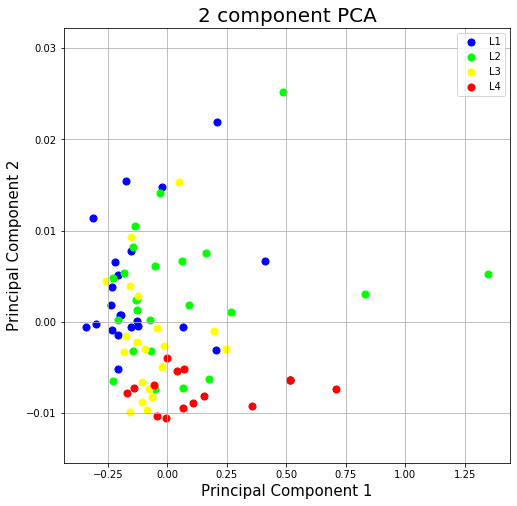

In [204]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['L1', 'L2', 'L3', 'L4']
colors = ['#0000FF', '#00FF00', '#FFFF00', '#FF0000']
for target, color in zip(targets,colors):
    indicesToKeep = principal_df['level'] == target
    ax.scatter(principal_df.loc[indicesToKeep, 'principal component 1']
               , principal_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [207]:
pca.explained_variance_ratio_

array([9.99238608e-01, 7.38632852e-04])

## Discussion

The relationship between topology of complex networks and language complexity is studied. The above approach to identify group of texts with the same topological feature in the network, thereby, drawing a parallel between topological features and language complexity. 

We can use Complex Network approach for rapid screening of texts.



Future work:

1. Consider more network metrics to better differentiate the clusters.

2. To examine change in each network metric across _reading levels_.

3. Compare results of the above approach with _linguistic methods_ of calculating language complexity